# Task 1 : Set up colab gpu runtime environment

In [28]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-jylxpef6
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-jylxpef6
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

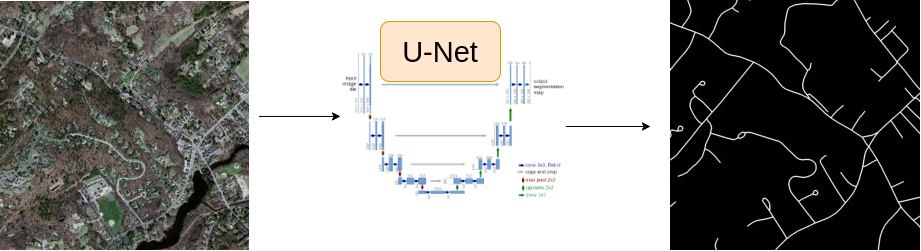

# Download Subset Dataset

In [29]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [30]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [31]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Task : 2 Setup Configurations

In [8]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 30
LR = 0.001
BATCH_SIZE = 16
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [33]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [34]:
idx = 2
row = df.loc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

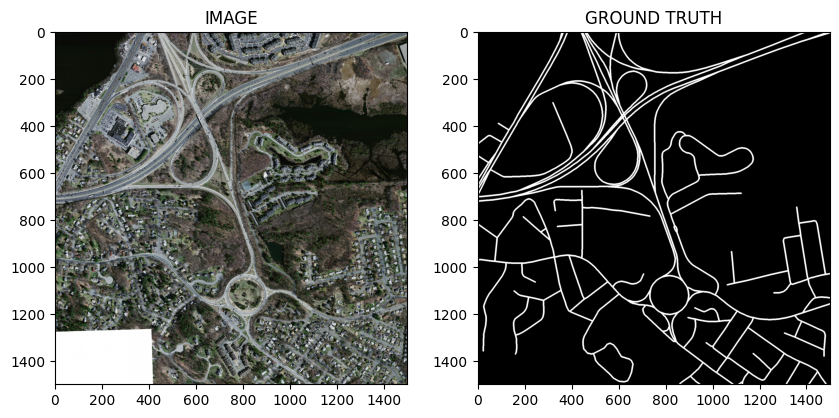

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [36]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [37]:
import albumentations as A

In [38]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ])

# Task 4 : Create Custom Dataset

In [39]:
from torch.utils.data import Dataset

In [40]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = df.loc[idx]
        image_path = DATA_DIR + row.images
        mask_path = DATA_DIR + row.masks
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask)

        return image, mask

In [41]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [42]:
print('Size of trainset:', len(trainset))
print('Size of validset:', len(validset))

Size of trainset: 159
Size of validset: 40


In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch


def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

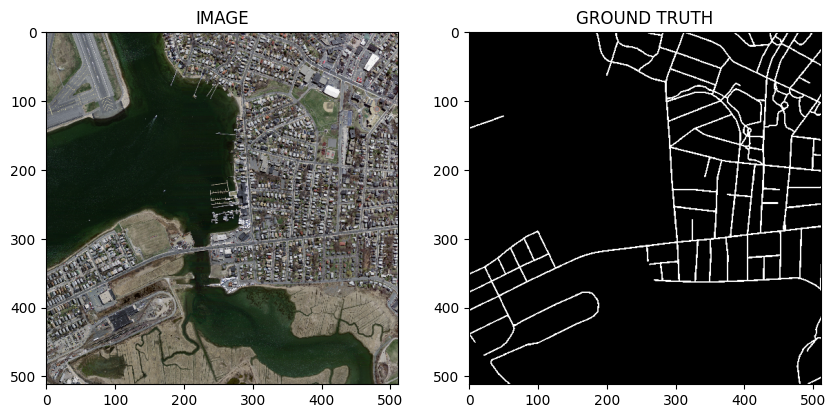

In [43]:
idx = 3
image, mask = trainset[idx]
show_image(image, mask)

# Task 5 : Load dataset into batches

In [44]:
from torch.utils.data import DataLoader

In [45]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [46]:
print('Size of trainloader:', len(trainloader))
print('Size of validloader:', len(validloader))

Size of trainloader: 10
Size of validloader: 3


In [47]:
for images, masks in trainloader:
    print(images.shape)
    print(masks.shape)
    break

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [5]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [9]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.backbone = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )

    def forward(self, images, masks=None):
        logits = self.backbone(images)

        if masks != None:
            return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

        return logits

In [50]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [51]:
def train_fn(dataloader, model, optimizer):
    model.train()

    total_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [52]:
def eval_fn(dataloader, model, optimizer):
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(dataloader)

# Task 8 : Train Model

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [54]:
best_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model, optimizer)
    if valid_loss < best_loss:
        torch.save(model.state_dict(), "best-model.pt")
        print("SAVED MODEL with loss:", valid_loss)
        best_loss = valid_loss

100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


SAVED MODEL with loss: 1.5208921829859416


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


SAVED MODEL with loss: 1.278856873512268


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


SAVED MODEL with loss: 1.140398343404134


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


SAVED MODEL with loss: 0.9872091213862101


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


SAVED MODEL with loss: 0.890964945157369


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


SAVED MODEL with loss: 0.8863054315249125


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


SAVED MODEL with loss: 0.7540174921353658


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


SAVED MODEL with loss: 0.7388958732287089


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


SAVED MODEL with loss: 0.7018807927767435


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


SAVED MODEL with loss: 0.6695588231086731


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


SAVED MODEL with loss: 0.6407974163691202


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


SAVED MODEL with loss: 0.627690593401591


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


SAVED MODEL with loss: 0.6002829372882843


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


SAVED MODEL with loss: 0.5971635182698568


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


SAVED MODEL with loss: 0.5798718730608622


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


SAVED MODEL with loss: 0.5701439678668976


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


SAVED MODEL with loss: 0.5650989015897115


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

SAVED MODEL with loss: 0.5477443436781565


# Task 9 : Inference

In [ ]:
idx = 13
model.load_state_dict(torch.load('best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
logits_mask = logits_mask > 0.5

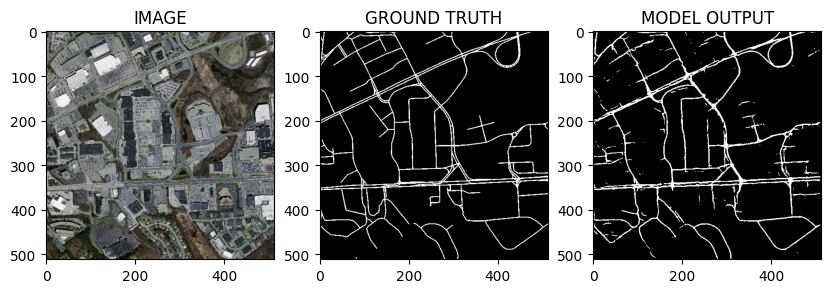

In [ ]:
show_image(image, mask, logits_mask.detach().cpu().squeeze(0))